## Performance Test
DATASET: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### Objetivo
Comparar o desempenho de pelo menos 6 diferentes modelos de Regressão com o dataset do house-prices.

### Racional
A ideia é **apenas** simplificar o dataset e iniciar os scores o mais cedo possível.

### Sequência
* Parte 0   - Preparação dos Dados
* Parte 1   – Regressão Lasso
* Parte 2   – Regressão Ridge
* Parte 3   – Regressão Ridge + Feature Selection Lasso
* Parte 4   – ElasticNet
* Parte 5   – Árvore de Decisão
* Parte 6   – Floresta Aleatória
* Parte 7   - Selecionando Melhor Modelo

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Parte 0 - Preparação dos Dados

In [9]:
# utilizar apenas o arquivo de treinamento (train.csv)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

len(df_train), len(df_test)

(1460, 1459)

In [10]:
target_col, seed, old_target = 'log_price', 12, 'SalePrice'

df_train[target_col] = np.log(df_train[old_target])
X_train, X_test, y_train = None, None, df_train[target_col]
go = globals()

for lab, df in zip(
    ['X_train', 'X_test'],
    [df_train, df_test]):
    #Engenharia de Feature - Diminuindo a Dispersão da SalePrice

    X = pd.get_dummies(df).copy()
    X = X.select_dtypes(include = [ 
        #filtrando agora por todos os data types númericos
        pre + tp + str(sz)
        for pre in ('', 'u')
        for tp in 'int, float'.split(', ')
        for sz in 2 ** np.arange(3, 7) # 8, 16, .., 64
        if tp != 'float' or (sz > 8 and pre != 'u')
    ])
    #Tratando NA pela média da coluna
    X = X.replace([-np.inf, np.inf], np.nan)\
        .fillna(X.mean())
    go[lab] = X

#Note q ambas as variáveis foram geradas no loop acima
X_train.drop([target_col, old_target, 'Id'], axis=1, inplace=True)
X_test.drop(['Id'], axis=1, inplace=True)

len(X_train.columns), len(X_test.columns)

(288, 270)

In [11]:
#Identificando Colunas faltantes no X_test
missing_columns = [
    col for col in X_train 
    if col not in X_test.columns
]
missing_columns

['Utilities_NoSeWa',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'Electrical_Mix',
 'GarageQual_Ex',
 'PoolQC_Fa',
 'MiscFeature_TenC']

In [12]:
#Gerando Dummies não presentes no DataFrame
X_test[ missing_columns ] = 0

In [13]:
#Padronizando os dados
scaller = StandardScaler()
scaller.fit(X_train)

X_train_std = scaller.transform(X_train)
X_test_std = scaller.transform(X_test)

In [14]:
#Criando Agregador de Resultados
df_results = pd.DataFrame(data = [
    ['Lasso', 0],
    ['Ridge', 0],
    ['Ridge_Lasso', 0],
    ['ElasticNet', 0],
    ['DecisionTree', 0],
    ['RandomForest', 0]
], columns = ['nome', 'rmse_teste'])
df_results

,nome,rmse_teste
0,Lasso,0
1,Ridge,0
2,Ridge_Lasso,0
3,ElasticNet,0
4,DecisionTree,0
5,RandomForest,0


### Parte 1 - Regressão Lasso

In [15]:
lasso = Lasso()

grid = GridSearchCV(
    lasso,
    {
        'alpha': np.arange(1, 601) / 10000
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 5, #K-Fold Validation com k = 5 
    n_jobs=8
)

grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=8,
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004 ,
       0....
       0.0553, 0.0554, 0.0555, 0.0556, 0.0557, 0.0558, 0.0559, 0.056 ,
       0.0561, 0.0562, 0.0563, 0.0564, 0.0565, 0.0566, 0.0567, 0.0568,
       0.0569, 0.057 , 0.0571, 0.0572, 0.0573, 0.0574, 0.0575, 0.0576,
       0.0577, 0.0578, 0.0579, 0.058 , 0.0581, 0.0582, 0.0583, 0.0584,
       0.0585, 0.0586, 0.0587, 0.0588, 0.0589, 0.059 , 0.0591, 0.0592,
       0.0593, 0.0594, 0.0595, 0.0596, 0.0597, 0.0598, 0.0599, 0.06  ])},
             scoring='neg_mean_squared_error')

In [16]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.093341,0.010697,0.002207,0.000621,0.0041,{'alpha': 0.0041},-0.010841,-0.022869,-0.021939,-0.011557,-0.036665,-0.020774,0.009401,1
42,0.088556,0.018678,0.002141,0.000486,0.0043,{'alpha': 0.0043},-0.010840,-0.022888,-0.021857,-0.011610,-0.036676,-0.020774,0.009393,2
41,0.110548,0.052069,0.005463,0.005340,0.0042,{'alpha': 0.0042},-0.010838,-0.022878,-0.021897,-0.011583,-0.036676,-0.020774,0.009399,3
39,0.111300,0.027659,0.002126,0.000774,0.004,{'alpha': 0.004},-0.010852,-0.022862,-0.021984,-0.011531,-0.036656,-0.020777,0.009402,4
43,0.094371,0.008612,0.002465,0.000407,0.0044,{'alpha': 0.0044},-0.010843,-0.022899,-0.021818,-0.011638,-0.036690,-0.020778,0.009392,5


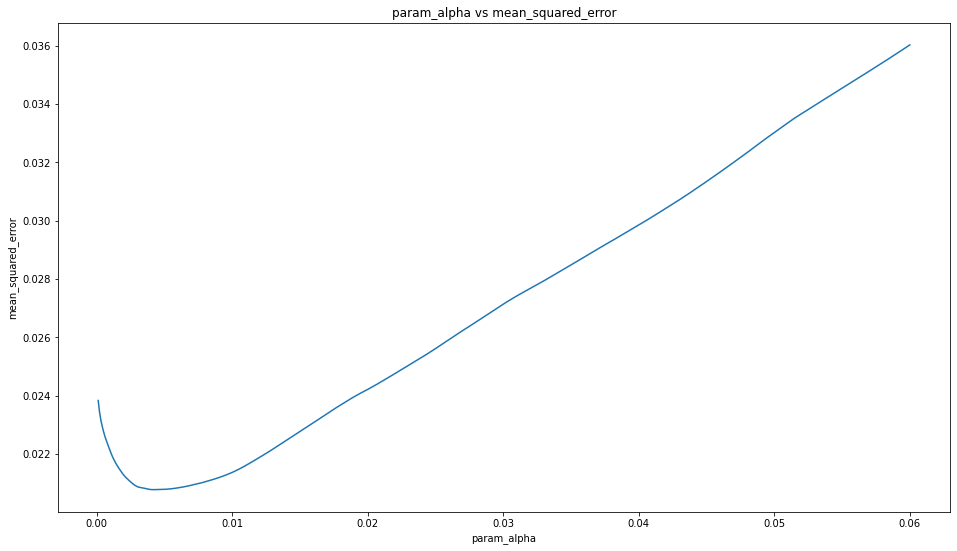

In [17]:
plt.figure(figsize=(16,9))
results.sort_values(by='param_alpha', inplace=True)

#Repare que o mean_test_score é a média de NEG_mean_squared_error entre os splits
results['mean_squared_error'] = -results['mean_test_score']

def show_plot(df, col_x, col_y):
    plt.plot(df[col_x], df[col_y])
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f'{col_x} vs {col_y}')
    plt.show()

show_plot(results, 'param_alpha', 'mean_squared_error')

Nosso melhor parâmetro é por tanto alpha = **0.0041**

In [23]:
def rmse_cv(model, x, k = 5):
    return np.sqrt(
        -cross_val_score(model, x, y_train, 
            scoring = "neg_mean_squared_error", cv = k)
        ).mean()

In [24]:
lasso = Lasso(alpha = 0.0041)

lasso.fit(X_train_std, y_train)

print('RMSE em Treinamento: ', 
  rmse_cv(lasso, X_train_std)
)

RMSE em Treinamento:  0.1404898472388253


In [25]:
#Guardando o resultado do Lasso
df_results['rmse_teste'][ df_results['nome'] == 'Lasso'] = 0.1404898472388253

### Parte 2 - Regressão Ridge

In [26]:
ridge = Ridge()

grid = GridSearchCV(
    ridge,
    {
        'alpha': np.arange(1, 250) * 4
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 5, #K-Fold Validation com k = 5 
    n_jobs=8
)

grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=8,
             param_grid={'alpha': array([  4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
        56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104,
       108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156,
       160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208,
       212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260,
       264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304,...
       680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728,
       732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780,
       784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 824, 828, 832,
       836, 840, 844, 848, 852, 856, 860, 864, 868, 872, 876, 880, 884,
       888, 892, 896, 900, 904, 908, 912, 916, 920, 924, 928, 932, 936,
       940, 944, 948, 952, 956, 960, 964, 968, 972, 976, 980, 984, 988,
       992, 996])},
             scoring='neg_mean_squared_er

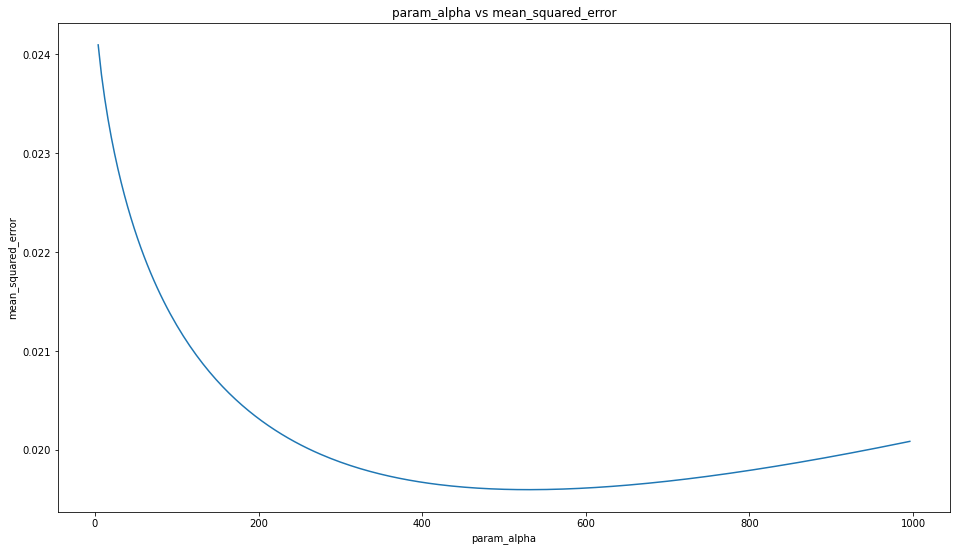

In [27]:
plt.figure(figsize=(16,9))

results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='param_alpha', inplace=True)

#Repare que o mean_test_score é a média de NEG_mean_squared_error entre os splits
results['mean_squared_error'] = -results['mean_test_score']

show_plot(results, 'param_alpha', 'mean_squared_error')

Nosso melhor parâmetro está entre 400 e 600.

Vamos rodar uma nova Busca mais acurada.

In [28]:
ridge = Ridge()

grid = GridSearchCV(
    ridge,
    {
        'alpha': 400 + np.arange(0, 800) / 4
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 5, #K-Fold Validation com k = 5 
    n_jobs=8
)

grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=8,
             param_grid={'alpha': array([400.  , 400.25, 400.5 , 400.75, 401.  , 401.25, 401.5 , 401.75,
       402.  , 402.25, 402.5 , 402.75, 403.  , 403.25, 403.5 , 403.75,
       404.  , 404.25, 404.5 , 404.75, 405.  , 405.25, 405.5 , 405.75,
       406.  , 406.25, 406.5 , 406.75, 407.  , 407.25, 407.5 , 407.75,
       408.  , 408.25, 408.5 , 408.75, 409.  , 409.25, 409.5 , 409.75,
       410.  , 410.25, 410.5 , 410.75, 411...
       586.  , 586.25, 586.5 , 586.75, 587.  , 587.25, 587.5 , 587.75,
       588.  , 588.25, 588.5 , 588.75, 589.  , 589.25, 589.5 , 589.75,
       590.  , 590.25, 590.5 , 590.75, 591.  , 591.25, 591.5 , 591.75,
       592.  , 592.25, 592.5 , 592.75, 593.  , 593.25, 593.5 , 593.75,
       594.  , 594.25, 594.5 , 594.75, 595.  , 595.25, 595.5 , 595.75,
       596.  , 596.25, 596.5 , 596.75, 597.  , 597.25, 597.5 , 597.75,
       598.  , 598.25, 598.5 , 598.75, 599.  , 599.25, 599.5 , 599.75])},
             scor

In [29]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
520,0.030127,0.002038,0.001878,0.000208,530,{'alpha': 530.0},-0.012986,-0.022696,-0.018451,-0.013403,-0.030453,-0.019598,0.006494,1
521,0.044266,0.011732,0.002153,0.000285,530.25,{'alpha': 530.25},-0.012986,-0.022697,-0.018451,-0.013404,-0.030452,-0.019598,0.006493,2
519,0.067403,0.028588,0.002099,0.000393,529.75,{'alpha': 529.75},-0.012986,-0.022696,-0.018452,-0.013402,-0.030454,-0.019598,0.006494,3
522,0.057575,0.007509,0.002177,0.000314,530.5,{'alpha': 530.5},-0.012987,-0.022697,-0.018451,-0.013404,-0.030451,-0.019598,0.006493,4
518,0.049785,0.015331,0.001937,0.000122,529.5,{'alpha': 529.5},-0.012986,-0.022696,-0.018452,-0.013401,-0.030455,-0.019598,0.006495,5


In [58]:
ridge = Ridge(alpha = 530)

ridge.fit(X_train_std, y_train)
y_pred = ridge.predict(X_train_std)

print('RMSE em Treinamento: ', 
  mean_squared_error(y_train, y_pred) ** .5
)

RMSE em Treinamento:  0.10479771096001349


In [31]:
#Guardando o resultado
df_results['rmse_teste'][ df_results['nome'] == 'Ridge'] = 0.10479771096001349

### Parte 3   – Regressão Ridge + Feature Selection Lasso

In [32]:
#Reutilizando o melhor Alpha para Lasso aqui
sel = SelectFromModel(Lasso(alpha=0.0041))


sel.fit(X_train, y_train)
best_features = X_train.columns[sel.get_support()]

best_features

Index(['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'YrSold', 'MSZoning_RL', 'MSZoning_RM',
       'Neighborhood_Crawfor', 'Condition1_Norm', 'Foundation_PConc',
       'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf',
       'HeatingQC_Ex', 'KitchenQual_TA', 'FireplaceQu_Gd', 'GarageType_Attchd',
       'SaleCondition_Abnorml'],
      dtype='object')

In [33]:
X_train_sel = X_train[best_features]
X_test_sel = X_test[best_features]

print(
    'Qtd de Features',
  '\nAntes : ', len(X_train.columns),
  '\nDepois:  ', len(X_train_sel.columns))

Qtd de Features 
Antes :  288 
Depois:   40


In [34]:
ridge = Ridge()

grid = GridSearchCV(
    ridge,
    {
        'alpha': np.arange(1, 400) / 50
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 5, #K-Fold Validation com k = 5 
    n_jobs=8
)

grid.fit(X_train_sel, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=8,
             param_grid={'alpha': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 ,
       1.12, 1.14, 1.16,...
       6.62, 6.64, 6.66, 6.68, 6.7 , 6.72, 6.74, 6.76, 6.78, 6.8 , 6.82,
       6.84, 6.86, 6.88, 6.9 , 6.92, 6.94, 6.96, 6.98, 7.  , 7.02, 7.04,
       7.06, 7.08, 7.1 , 7.12, 7.14, 7.16, 7.18, 7.2 , 7.22, 7.24, 7.26,
       7.28, 7.3 , 7.32, 7.34, 7.36, 7.38, 7.4 , 7.42, 7.44, 7.46, 7.48,
       7.5 , 7.52, 7.54, 7.56, 7.58, 7.6 , 7.62, 7.64, 7.66, 7.68, 7.7 ,
       7.72, 7.74, 7.76, 7.78, 7.8 , 7.82, 7.84, 7.86, 7.88, 7.9 , 7.92,
       7.94, 7.96, 7.98])},
             scoring='neg_mean_squared_error')

In [35]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
317,0.017010,0.003616,0.012576,0.003260,6.36,{'alpha': 6.36},-0.016526,-0.024585,-0.018626,-0.015430,-0.036967,-0.022427,0.007928,1
316,0.012884,0.003282,0.007779,0.001101,6.34,{'alpha': 6.34},-0.016526,-0.024585,-0.018626,-0.015431,-0.036966,-0.022427,0.007928,2
318,0.015990,0.002970,0.009218,0.001293,6.38,{'alpha': 6.38},-0.016526,-0.024584,-0.018625,-0.015430,-0.036967,-0.022427,0.007929,3
315,0.012891,0.000224,0.007891,0.001283,6.32,{'alpha': 6.32},-0.016526,-0.024585,-0.018626,-0.015431,-0.036965,-0.022427,0.007927,4
319,0.015301,0.005243,0.017389,0.017006,6.4,{'alpha': 6.4},-0.016525,-0.024584,-0.018625,-0.015429,-0.036968,-0.022427,0.007929,5


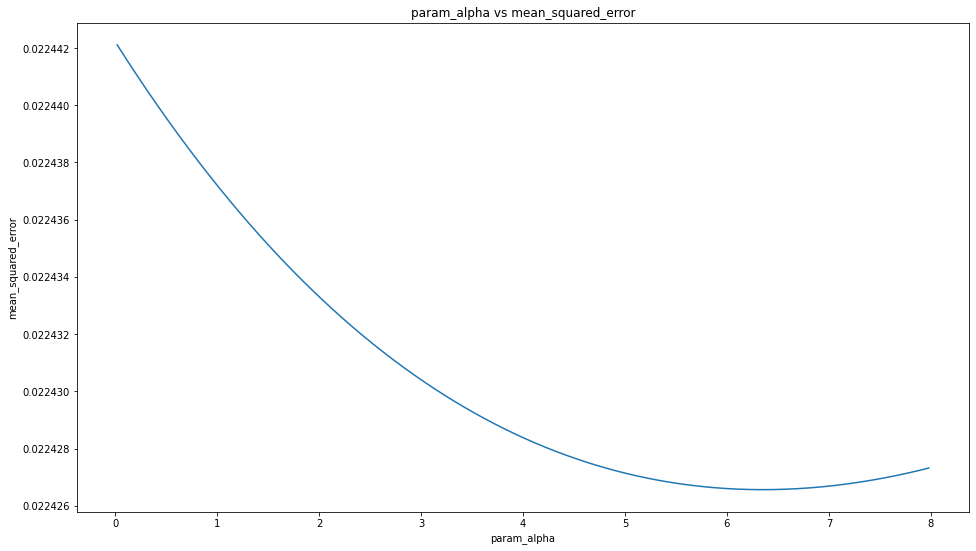

In [36]:
plt.figure(figsize=(16,9))
results.sort_values(by='param_alpha', inplace=True)

#Repare que o mean_test_score é a média de NEG_mean_squared_error entre os splits
results['mean_squared_error'] = -results['mean_test_score']

show_plot(results, 'param_alpha', 'mean_squared_error')

Com Feature Selection o nosso melhor parâmetro agora é **6.36**

In [37]:
ridge = Ridge(alpha = 6.36)

ridge.fit(X_train_sel, y_train)

print('RMSE de Treinamento: ', 
  rmse_cv(ridge, X_train_sel)
)

RMSE de Treinamento:  0.14766174133454157


In [38]:
#Guardando o resultado
df_results['rmse_teste'][ df_results['nome'] == 'Ridge_Lasso'] = 0.14766174133454157

### Parte 4 – ElasticNet

In [39]:
elnet = ElasticNet()

grid = GridSearchCV(
    elnet,
    {
        'alpha': np.arange(1, 20) / 500,
        'l1_ratio': np.arange(1, 30) / 500,
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 5, #K-Fold Validation com k = 5 
    n_jobs = 8
)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=8,
             param_grid={'alpha': array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034, 0.036,
       0.038]),
                         'l1_ratio': array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034, 0.036,
       0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052, 0.054,
       0.056, 0.058])},
             scoring='neg_mean_squared_error')

In [40]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
550,0.139749,0.017756,0.002165,0.000656,0.038,0.058,"{'alpha': 0.038, 'l1_ratio': 0.058}",-0.011384,-0.022670,-0.021361,-0.011397,-0.034935,-0.020349,0.008714,1
549,0.181268,0.048590,0.007028,0.006405,0.038,0.056,"{'alpha': 0.038, 'l1_ratio': 0.056}",-0.011427,-0.022686,-0.021416,-0.011398,-0.034947,-0.020375,0.008711,2
548,0.147961,0.023383,0.002847,0.000602,0.038,0.054,"{'alpha': 0.038, 'l1_ratio': 0.054}",-0.011470,-0.022704,-0.021472,-0.011401,-0.034960,-0.020401,0.008709,3
521,0.153245,0.027601,0.002844,0.000865,0.036,0.058,"{'alpha': 0.036, 'l1_ratio': 0.058}",-0.011452,-0.022722,-0.021524,-0.011389,-0.035009,-0.020419,0.008733,4
547,0.181871,0.036510,0.002515,0.000324,0.038,0.052,"{'alpha': 0.038, 'l1_ratio': 0.052}",-0.011514,-0.022724,-0.021539,-0.011406,-0.034975,-0.020432,0.008706,5


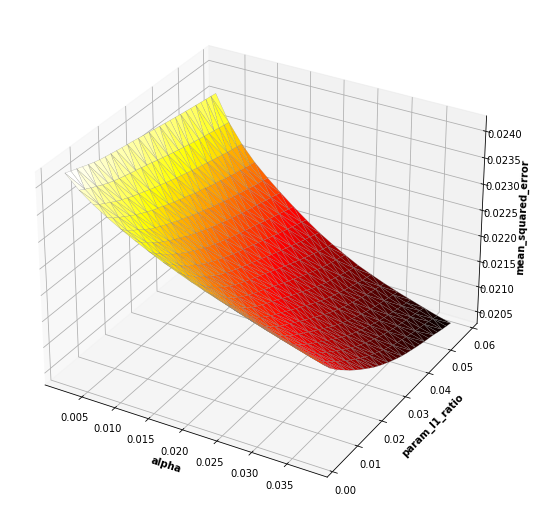

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook #para o próximo trab

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

results.sort_values(by='param_l1_ratio', inplace=True)
fig.set_figheight(16)
fig.set_figwidth(9)

#Repare que o mean_test_score é a média de NEG_mean_squared_error entre os splits
results['mean_squared_error'] = -results['mean_test_score']
results['alpha'] = results['param_alpha']

def show_plot(df, col_x, col_y, col_z):
    x, y, z = df[col_x].to_numpy().astype(float), \
        df[col_y].to_numpy().astype(float), \
        df[col_z].to_numpy().astype(float)
    ax.plot_trisurf(x, y, z, cmap = plt.get_cmap('hot'), 
                         linewidth = 0.2,  
                         antialiased = True, 
                         edgecolor = 'grey')

    ax.set_xlabel(col_x, fontweight ='bold')  
    ax.set_ylabel(col_y, fontweight ='bold')  
    ax.set_zlabel(col_z, fontweight ='bold') 

show_plot(results, 'alpha', 'param_l1_ratio', 'mean_squared_error')


Conforme vimos acima os melhores parâmetros são {'alpha': 0.038, 'l1_ratio': 0.058}	

In [42]:
elnet = ElasticNet(**{'alpha': 0.038, 'l1_ratio': 0.058})

elnet.fit(X_train_std, y_train)

print(
    'RMSE de Treinamento: ', 
    rmse_cv(elnet, X_train_std)
)

RMSE de Treinamento:  0.139416335396242


In [43]:
#Guardando o resultado
df_results['rmse_teste'][ df_results['nome'] == 'ElasticNet'] = 0.139416335396242

### Parte 5 - Árvore de Decisão


In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor 

In [45]:
onetre = DecisionTreeRegressor()

grid = GridSearchCV(
    onetre,
    {
        'max_depth': [ 10, 15, 20],
        'min_samples_split': [.1, .5, .9],
        'min_samples_leaf': [.1, .5, .9],
        'max_features': ['sqrt', 'log2']
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 10, #K-Fold Validation com k = 10
    n_jobs = 8
)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=8,
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [0.1, 0.5, 0.9],
                         'min_samples_split': [0.1, 0.5, 0.9]},
             scoring='neg_mean_squared_error')

In [46]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

#Exibindo os melhores resultados
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014321,0.003367,0.002154,0.000809,10,sqrt,0.1,0.1,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",-0.062034,...,-0.114741,-0.076628,-0.073078,-0.065942,-0.059559,-0.066283,-0.085556,-0.072677,0.016520,1
36,0.008473,0.000912,0.001444,0.000289,20,sqrt,0.1,0.1,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",-0.060628,...,-0.101132,-0.098092,-0.063174,-0.057477,-0.099172,-0.087737,-0.080482,-0.077797,0.016887,2
18,0.008336,0.001848,0.001533,0.000431,15,sqrt,0.1,0.1,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",-0.069205,...,-0.108265,-0.142599,-0.071285,-0.076137,-0.059860,-0.081675,-0.084107,-0.085077,0.022779,3
45,0.011039,0.001045,0.001720,0.000114,20,log2,0.1,0.1,"{'max_depth': 20, 'max_features': 'log2', 'min...",-0.088017,...,-0.107365,-0.113538,-0.095978,-0.126068,-0.080786,-0.083232,-0.070814,-0.096874,0.017002,4
19,0.009105,0.001220,0.001804,0.000352,15,sqrt,0.1,0.5,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",-0.091103,...,-0.115635,-0.158161,-0.091921,-0.104679,-0.080571,-0.083724,-0.117928,-0.103674,0.021623,5


Os **melhores** parâmetros são os abaixo:

In [47]:
results.iloc[0]['params']

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

In [49]:
#Gerando a Árvore com os melhores parâmetros
onetre = DecisionTreeRegressor(**results.iloc[0]['params'])

onetre.fit(X_train_std, y_train)

print(
    'RMSE de Validação: ', 
    rmse_cv(onetre, X_train_std)
)

RMSE de Validação:  0.2791627157659554


In [50]:
#Guardando o resultado
df_results['rmse_teste'][ df_results['nome'] == 'DecisionTree'] = 0.2791627157659554

### Parte 3 - Floresta Aleatória

* Vamos utilizar apenas o arquivo de treinamento (train.csv)
* Repita o processo anterior para produzir uma Floresta Aleatória
utilizando o método RandomForestRegressor da Sklearn.

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
rf_reg = RandomForestRegressor(n_jobs=1)

grid = GridSearchCV(
    rf_reg,
    {
        'n_estimators': [100, 120],
        'max_depth': [ 10, 15, 20],
        'criterion': ['mse', 'mae'],
        'min_samples_split': [.1, .5],
        'min_samples_leaf': [.1, .5],
        'max_features': ['sqrt']
    },
    scoring='neg_mean_squared_error', #negativo do MSE
    cv = 10, #K-Fold Validation com k = 10
    n_jobs = 8
)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=1), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [10, 15, 20],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [0.1, 0.5],
                         'min_samples_split': [0.1, 0.5],
                         'n_estimators': [100, 120]},
             scoring='neg_mean_squared_error')

In [53]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
8,0.711499,0.208234,0.032655,0.008344,mse,15,sqrt,0.1,0.1,100,...,-0.079523,-0.094500,-0.054705,-0.066780,-0.053075,-0.064086,-0.066127,-0.067157,0.011719,1
16,0.792046,0.134141,0.036777,0.016680,mse,20,sqrt,0.1,0.1,100,...,-0.081203,-0.094028,-0.053817,-0.064491,-0.055942,-0.064498,-0.069179,-0.067386,0.011690,2
9,0.834792,0.137230,0.040597,0.007894,mse,15,sqrt,0.1,0.1,120,...,-0.085428,-0.095015,-0.050402,-0.064037,-0.053198,-0.065155,-0.071069,-0.068173,0.013330,3
0,0.693948,0.115197,0.033606,0.007711,mse,10,sqrt,0.1,0.1,100,...,-0.083234,-0.096149,-0.054969,-0.066146,-0.055005,-0.062257,-0.071652,-0.068254,0.012462,4
17,0.817808,0.183474,0.043374,0.013463,mse,20,sqrt,0.1,0.1,120,...,-0.082609,-0.092286,-0.052481,-0.065501,-0.057997,-0.067046,-0.068092,-0.068426,0.011669,5


Os nossos melhores parâmetros são portando:

In [54]:
results.iloc[0]['params']

{'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 100}

In [55]:
rf_reg = RandomForestRegressor(
    **results.iloc[0]['params'], 
    n_jobs=8
)

rf_reg.fit(X_train_std, y_train)

print(
    'RMSE de Treinamento: ', 
    rmse_cv(rf_reg, X_train_std)
)

RMSE de Treinamento:  0.26032647063748204


In [56]:
#Guardando o resultado
df_results['rmse_teste'][ df_results['nome'] == 'RandomForest'] = 0.26032647063748204

### Parte 7 - Conclusão

In [57]:
df_results.sort_values(by='rmse_teste', inplace=True)
df_results

,nome,rmse_teste
1,Ridge,0.104798
3,ElasticNet,0.139416
0,Lasso,0.140490
2,Ridge_Lasso,0.147662
5,RandomForest,0.260326
4,DecisionTree,0.279163


Com isso vemos q a Regressão com Ridge obteve um melhor resultado.

Na próxima prática estarei adicionando SVM e XGBoost.